# **`CA4`** - *Random Forest*
    Kiarash Norouzi
    810197012

<hr>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import random

## `Data Preprocessing`

In [4]:
# RANDOM_STATE_DT = 14
# RANDOM_STATE_SPLIT = 27
# RANDOM_STATE = 115
# random.seed(12)
data = pd.read_csv('data.csv')
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [5]:
# Checking if there is a Missing Data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age         303 non-null int64
sex         303 non-null int64
cp          303 non-null int64
trestbps    303 non-null int64
chol        303 non-null int64
fbs         303 non-null int64
restecg     303 non-null int64
thalach     303 non-null int64
exang       303 non-null int64
oldpeak     303 non-null float64
slope       303 non-null int64
ca          303 non-null int64
thal        303 non-null int64
target      303 non-null int64
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


    Checking the correlation between the data

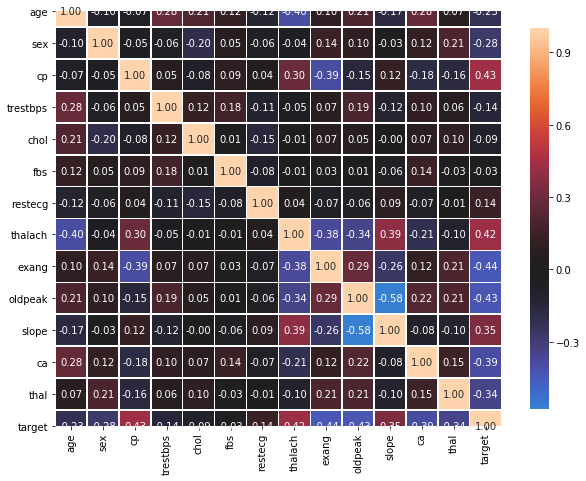

In [6]:
def correlation_heatmap(train):
    correlations = train.corr()
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    plt.show();
correlation_heatmap(data)

    Luckily, decision trees and boosted trees algorithms are immune to multicollinearity by nature.
    Seems There is no need to preprocess the data

## **PART 1** - `Testing A Decision Tree`

Accuracy :  0.7545409836065565


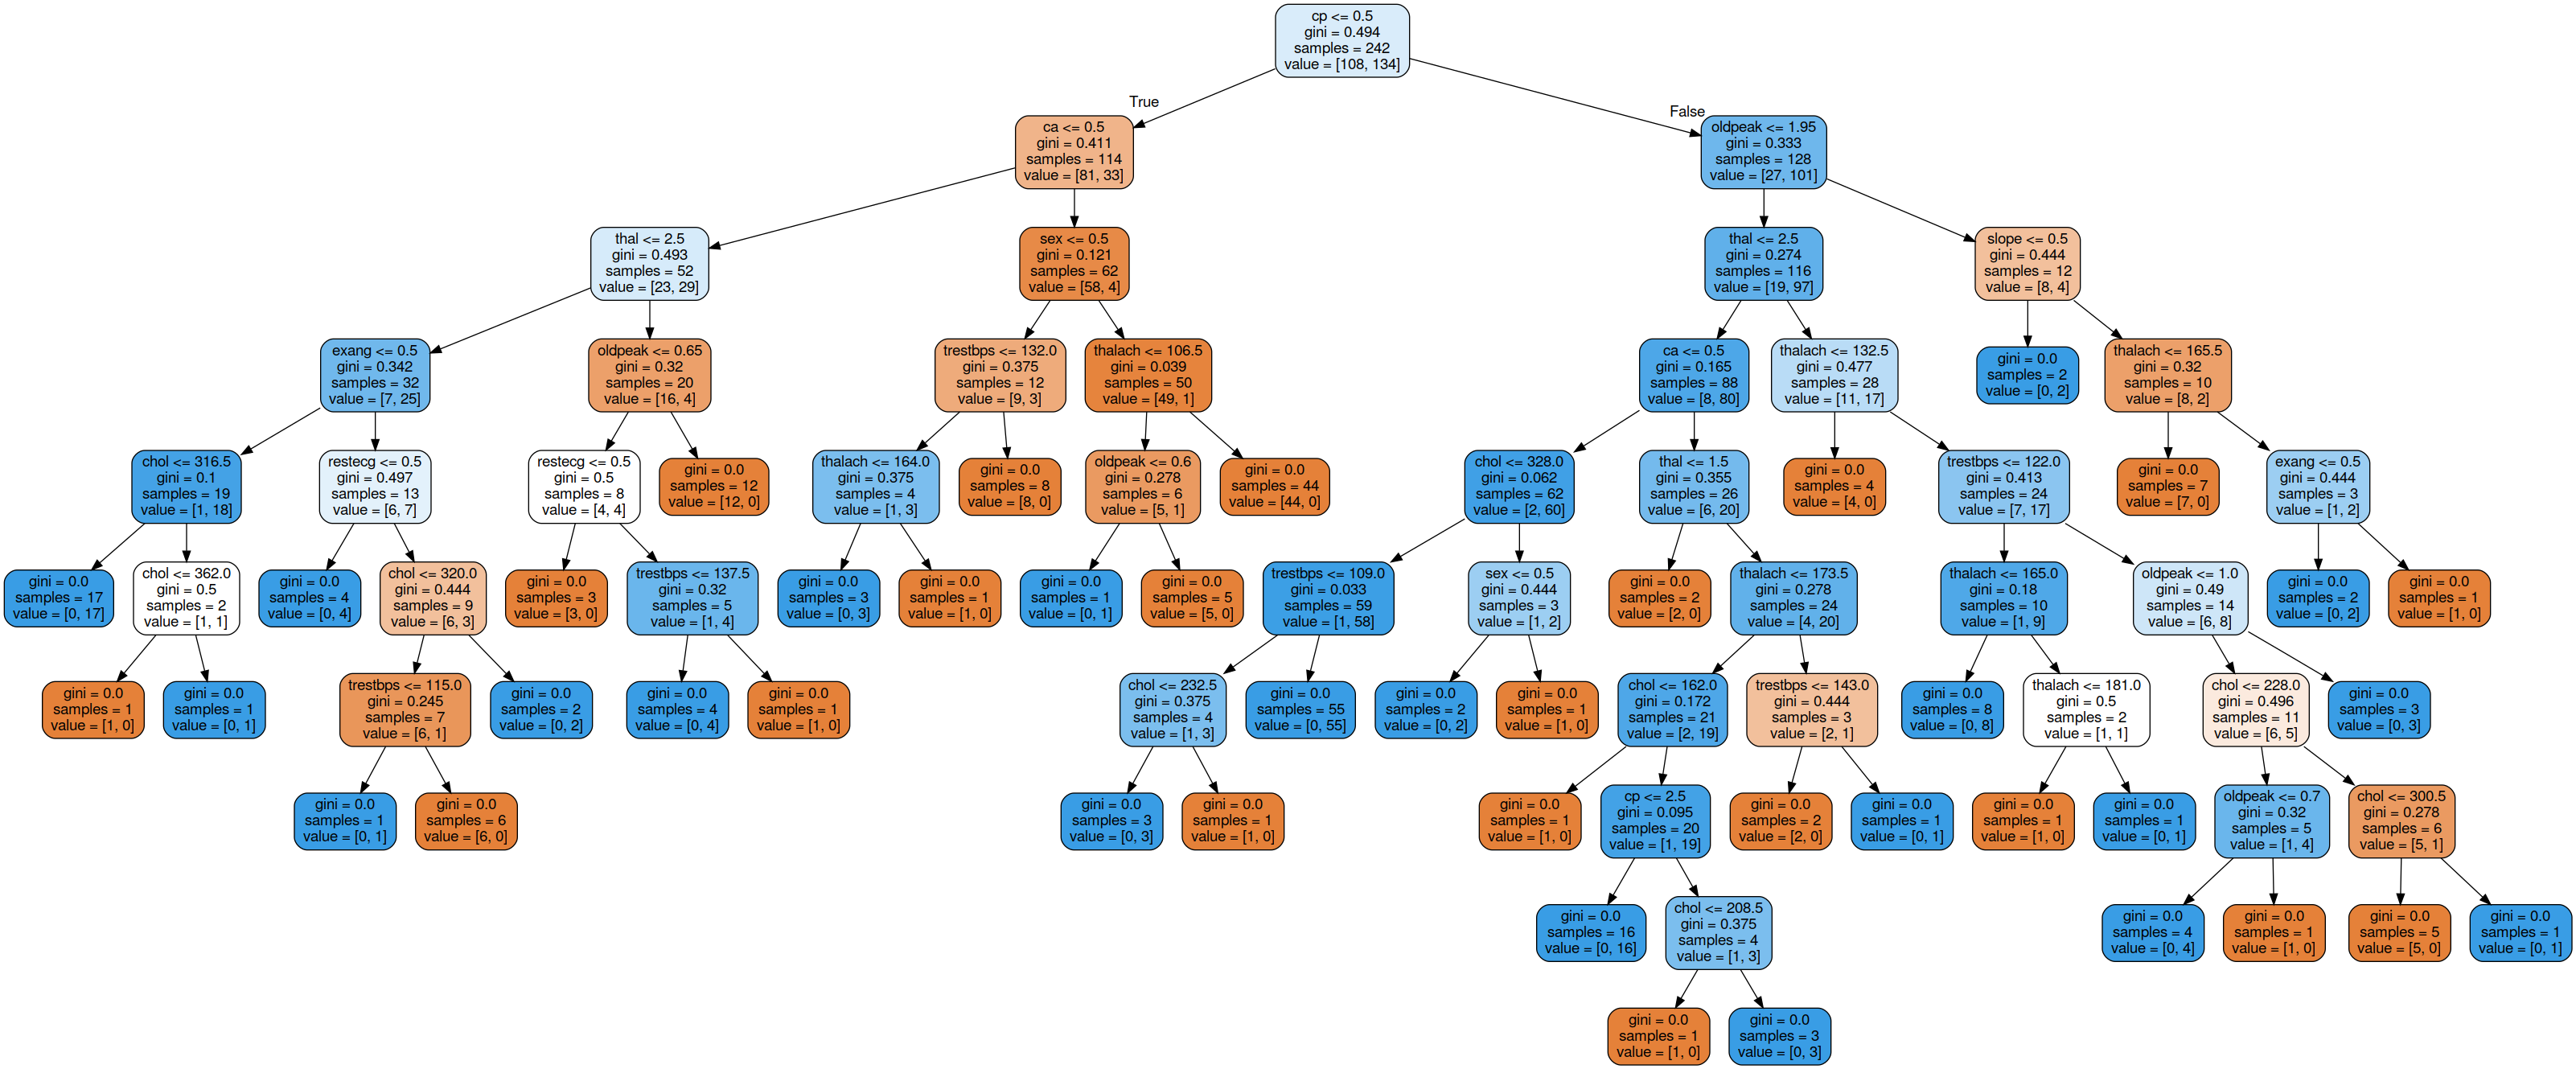

In [480]:
y = data['target']
X = data.drop(columns=['target'], inplace=False)

# the_max = 0
# for j in range(1000):
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=j)
#     for i in range(1000):
#         tree_clf = DecisionTreeClassifier(random_state=i)
#         tree_clf.fit(X_train, y_train);
#         y_pred = tree_clf.predict(X_test)
#     #     print(classification_report(y_test, y_pred));
#     #     print(accuracy_score(y_test, y_pred))
#         if accuracy_score(y_test, y_pred) > the_max:
#             print(i, j)
#             the_max = accuracy_score(y_test, y_pred)

res = 0
itr = 1000
for i in range(itr):
    RANDOM_STATE = i
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
    tree_clf = DecisionTreeClassifier(random_state=RANDOM_STATE)
    tree_clf.fit(X_train, y_train);
    y_pred = tree_clf.predict(X_test)
    # print(classification_report(y_test, y_pred));
    res += accuracy_score(y_test, y_pred)
print("Accuracy : ", res/itr)

export_graphviz(
    tree_clf,
    out_file="decision_tree.dot",
    feature_names=X.columns,
    rounded=True,
    filled=True
)
from subprocess import call
call(['dot', '-Tpng', 'decision_tree.dot', '-o', 'tree.png'])
from IPython.display import Image
Image(filename = 'tree.png')

## **PART 2** - `Creating A Random Forest`

### **PART 2.1 and 2.2** - `Random Data with Bagging`

In [481]:
class RandomDataBagging:
    def __init__(self, number_of_trees=5, number_of_samples=150, random_state=0):
        self.nof_trees = number_of_trees
        self.nof_samples = number_of_samples
        self.random_state = random_state
        
    def fit(self, X_train, y_train):
        the_data = pd.concat([X_train, y_train], axis=1)
        Xs = [the_data.sample(self.nof_samples, replace=True, random_state=self.random_state) for i in range(self.nof_trees)]
        self.clfs = [DecisionTreeClassifier(random_state=self.random_state) for i in range(self.nof_trees)]
        for i in range(self.nof_trees):
            _x = Xs[i].drop(columns=['target'], inplace=False)
            _y = Xs[i]['target']
            self.clfs[i].fit(_x, _y)
            
    def predict(self, X_test, verbos=1):
        preds = []
        for i in range(self.nof_trees):
            the_pred = self.clfs[i].predict(X_test)
            preds.append(the_pred)
            if verbos == 1:
                print(f"Tree Number {i+1} Accuracy : ", accuracy_score(y_test, the_pred))
        np_preds = np.array(preds)
        sum_of_them = np_preds.sum(axis=0)
        bagging = []
        for item in sum_of_them:
            if item >= int(self.nof_trees/2)+1:
                bagging.append(1)
            else:
                bagging.append(0)
        return bagging
    
if __name__ == '__main__':
    res = 0
    itr = 1000
    for i in range(itr):
        RANDOM_STATE = i
        bg = RandomDataBagging(5, 150, RANDOM_STATE)
        X_train1, X_test1, y_train1, y_test1 = train_test_split(
            data.drop(columns=['target'], inplace=False), 
            data['target'], 
            test_size=0.2, 
            random_state=RANDOM_STATE
        )
        bg.fit(X_train1, y_train1)
        res += accuracy_score(y_test1, bg.predict(X_test1, verbos=0))
#         print("Accuracy with Bagging : ", accuracy_score(y_test1, bg.predict(X_test1, verbos=0)))
    print("Accuracy with Bagging : ", res/itr)

Accuracy with Bagging :  0.7273114754098351


### **PART 2.3** - `Deleting each feature`

In [11]:
if __name__ == '__main__':
    for col in data.columns[:len(data.columns)-1]:
        new_data = data.drop(columns=[col], inplace=False)
        X_train1, X_test1, y_train1, y_test1 = train_test_split(
            new_data.drop(columns=['target'], inplace=False), 
            new_data['target'], 
            test_size=0.2,
#             shuffle=False
            random_state=RANDOM_STATE
        ) 
        bg = DecisionTreeClassifier(random_state=RANDOM_STATE)
        bg.fit(X_train1, y_train1)
        print("Accuracy without {:10s} : ".format(col), accuracy_score(y_test1, bg.predict(X_test1)))

NameError: name 'RANDOM_STATE' is not defined

### **PART 2.4** - `Random five Feature DTC`

In [483]:
if __name__ == '__main__':
    res = 0
    itr = 1000
    for i in range(1000):
        RANDOM_STATE = i
        random.seed(RANDOM_STATE)
        _cols = random.sample(set(data.columns[:len(data.columns)-1]), 8)
        the_data = data.drop(columns=_cols, inplace=False)
        _X = the_data.drop(columns=['target'], inplace=False)
        _y = the_data['target']
        X_train1, X_test1, y_train1, y_test1 = train_test_split(_X, _y, test_size=0.2, random_state=RANDOM_STATE)
        dtc = DecisionTreeClassifier(random_state=RANDOM_STATE)
        dtc.fit(X_train1, y_train1)
#     print("Accuracy : ", accuracy_score(y_test1, dtc.predict(X_test1)))
        res += accuracy_score(y_test1, dtc.predict(X_test1))
    print("Accuracy : ", res/itr)

Accuracy :  0.6893442622950816


### **PART 2.5** - `THE RANDOM FORREST`

In [484]:
class RandomForest:
    def __init__(self, number_of_trees=5, number_of_samples=150, random_state=0):
        self.nof_trees = number_of_trees
        self.nof_samples = number_of_samples
        self.random_state = random_state
        
    def fit(self, X_train, y_train):
        _data = pd.concat([X_train, y_train], axis=1)
        self.clfs = [DecisionTreeClassifier(random_state=self.random_state) for i in range(self.nof_trees)]
        self.tree_cols = []
        for i in range(self.nof_trees):
            _cols = random.sample(set(_data.columns[:len(_data.columns)-1]), 8)
            the_data = _data.drop(columns=_cols, inplace=False)
            the_data = the_data.sample(self.nof_samples, replace=True, random_state=self.random_state)
            _x = the_data.drop(columns=['target'], inplace=False)
            _y = the_data['target']
            self.clfs[i].fit(_x, _y)
            self.tree_cols.append(_x.columns)
            
    def predict(self, X_test, verbos=1):
        preds = []
        for i in range(self.nof_trees):
            the_pred = self.clfs[i].predict(X_test.filter(self.tree_cols[i]))
            preds.append(the_pred)
            if verbos == 1:
                print(f"Tree Number {i+1} Accuracy : ", accuracy_score(y_test, the_pred))
        np_preds = np.array(preds)
        sum_of_them = np_preds.sum(axis=0)
        bagging = []
        for item in sum_of_them:
            if item >= int(self.nof_trees/2)+1:
                bagging.append(1)
            else:
                bagging.append(0)
        return bagging
    
if __name__ == '__main__':
    res = 0
    itr = 1000
    for i in range(itr):
        RANDOM_STATE = i
        random.seed(RANDOM_STATE)
        bg = RandomForest(5, 150, random_state=RANDOM_STATE)
        _X = data.drop(columns=['target'], inplace=False)
        _y = new_data['target']
        X_train1, X_test1, y_train1, y_test1 = train_test_split(_X, _y, test_size=0.2, random_state=RANDOM_STATE)
        bg.fit(X_train1, y_train1)
#         print("Accuracy with Bagging : ", accuracy_score(y_test1, bg.predict(X_test1, verbos=0)))
        res += accuracy_score(y_test1, bg.predict(X_test1, verbos=0))
    print("Accuracy : ", res/itr)

Accuracy :  0.7483770491803271
